# Objective
- Perform sequential imputation experiments and plot results as described in the publication (see README.md)

Note: Figure numbers correspond to the publication.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import KFold


import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from shapely.geometry import Point


# Read in processed precipitation timeseries and metadata

In [2]:
stations_path = '../data_processed/NRCS_dates_2008_2017.csv'
stations_df = pd.read_csv(stations_path)

Metadata = pd.read_csv('../data_processed/Metadata_processed.csv')
Metadata['StationID'] = Metadata['StationID'].apply(str)

display(stations_df)

,Date,Year,Month,Day,1030,317,1061,1041,1143,335,...,2132,2154,2158,2162,2139,0484,0761,2192,0951,0909
0,2008-01-01,2008,1,1,7.62,0.00,0.00,0.00,NaN,5.08,...,0.0,NaN,NaN,NaN,0.0,0.00,0.00,NaN,0.00,7.62
1,2008-01-02,2008,1,2,2.54,0.00,2.54,0.00,NaN,2.54,...,0.0,NaN,NaN,NaN,0.0,2.54,2.54,NaN,0.00,2.54
2,2008-01-03,2008,1,3,2.54,7.62,2.54,2.54,NaN,0.00,...,0.0,NaN,NaN,NaN,0.0,0.00,0.00,NaN,0.00,22.86
3,2008-01-04,2008,1,4,0.00,2.54,2.54,2.54,NaN,0.00,...,0.0,NaN,NaN,NaN,0.0,2.54,0.00,NaN,2.54,25.40
4,2008-01-05,2008,1,5,2.54,0.00,2.54,2.54,NaN,2.54,...,0.0,NaN,NaN,NaN,0.0,2.54,2.54,NaN,0.00,33.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2017-12-27,2017,12,27,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
3649,2017-12-28,2017,12,28,2.54,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,2.54,0.0,0.00,7.62
3650,2017-12-29,2017,12,29,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,25.40
3651,2017-12-30,2017,12,30,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,25.40


In [3]:
Metadata_gdf = gpd.GeoDataFrame(Metadata, geometry=[Point(xy) for xy in zip(Metadata['Longitude'], Metadata['Latitude'])])

In [4]:
Metadata_gdf

,StationID,Elevation,Latitude,Longitude,geometry
0,2138,6445,37.67455,-109.36429,POINT (-109.36429 37.67455)
1,1030,10960,40.35098,-106.38142,POINT (-106.38142 40.35098)
2,484,6240,41.03333,-107.65000,POINT (-107.65 41.03333)
3,317,7440,41.05413,-107.26609,POINT (-107.26609 41.05413)
4,1061,9080,40.06153,-107.00955,POINT (-107.00955 40.06153)
...,...,...,...,...,...
147,859,8950,41.00289,-106.90848,POINT (-106.90848 41.00289)
148,864,8641,39.96450,-110.98845,POINT (-110.98845 39.9645)
149,869,9540,40.34703,-106.09433,POINT (-106.09433 40.34703)
150,874,11000,37.47922,-106.80170,POINT (-106.8017 37.47922)


# Read files for plotting

In [5]:
UCWRR_path = '../data_raw/UCWRR_shapefile/HUC2_14.shp'
UCWRR_Boundary = gpd.read_file(UCWRR_path)
DEMraster_path = '../data_raw/UCWRR_DEM_800m.tif'

# Some functions

In [6]:
def segregate_stations(stations_df, output=True):

    incomplete_stations = stations_df.count() < 3653
    complete_stations = stations_df.count() == 3653

    start_col = 4 # first 4 columns are Date | Year | Month | Day

    number_incomplete_stations = sum(incomplete_stations[start_col:])
    number_complete_stations = sum(complete_stations[start_col:])
    if output == True:
        print (str(stations_df.shape[1]-start_col) + ' stations')
        print (str(number_complete_stations) + ' complete stations')
        print (str(number_incomplete_stations) + ' incomplete stations')

    Complete_df = stations_df.loc[:,complete_stations]
    Complete_df = Complete_df.iloc[:,start_col:]
    Incomplete_df = stations_df.loc[:,incomplete_stations]
    
    ## Final quality control by setting negative values to zero. There are a couple.
    Complete_df = Complete_df.mask(Complete_df < 0, 0.0)
    Incomplete_df = Incomplete_df.mask(Incomplete_df < 0, 0.0)
    
    return (Complete_df, Incomplete_df)

def get_NSE(labels, predictions):
    nse_num = mean_squared_error(labels, predictions)
    nse_den = mean_squared_error(labels, np.repeat(np.mean(labels), labels.shape[0]))
    nse = 1 - nse_num/nse_den
    return nse

def plot_results(rf, train_features, train_labels, test_features, test_labels):

    
###### Uncomment if plots of training data are desired ###
#     training_pred = rf.predict(train_features)    
#     train_NSE = get_NSE(train_labels, training_pred)

#     plt.scatter(train_labels, training_pred, s=5, alpha=0.7)
#     plt.xlabel('True Value (mm)')
#     plt.ylabel('Predicted Value (mm)')
#     plt.title('Precipitation: Training')
#     sns.set(font_scale=1.35, style='whitegrid') 
#     plot_end = np.max([training_pred, train_labels])
#     plt.plot([0, plot_end],[0, plot_end], '--')
#     plt.savefig('sampleImpute_training.png',dpi=300, bbox_inches='tight')
#     plt.show()

#     print ("Training correlation between prediction and true value: ")
#     print (np.corrcoef(training_pred, train_labels)[0,1])
#     print ("NSE (train): " + str(train_NSE))

############################################################

    predictions = rf.predict(test_features)
    nse_test = get_NSE(test_labels, predictions)
    
    fig, ax = plt.subplots()
    plt.scatter(test_labels, predictions, s=5, alpha=1)
    plt.xlabel('True Value (mm)')
    plt.ylabel('Predicted Value (mm)')
    plt.title('Precipitation: Testing')

    sns.set(font_scale=1.35, style='whitegrid')
    plot_end = np.max([test_labels, predictions])
    plot_end = 55
    plt.plot([0, plot_end],[0, plot_end], '--')
    
    textstr = "$NSE$ = " + str(round(nse_test,2))
    plt.title(textstr)

#     plt.savefig('sampleImpute_testing.png',dpi=300, bbox_inches='tight')
    plt.show()
    print ("NSE (test): " + str(nse_test))
    return


def get_mutual_corr(features, target, to_print = True):
    mutual_corr = [np.corrcoef(features[item], target)[0,1] for item in features.columns]
    
    features_corr = [(feature, round(information, 2)) for feature, information in zip(features.columns, mutual_corr)]
    features_corr = sorted(features_corr, key = lambda x: x[1], reverse = True)
    
    if to_print == True:
        [print('Variable: {:20} Mutual_Corr: {}'.format(*pair)) for pair in features_corr];
    return features_corr

def get_RF_NSE(ID, Complete_df, Complete_indices, fraction_missing = 0.2):
    """
    This function imputes missing data using random forests, and returns the imputed values, along
    with various performance metrics.
    
    imputed labels: imputed values
    nse_test: Nash-Sutcliffe efficiency
    test_dry_err: Fraction of dry days that are correctly predicted (or PE/100)
    nse_test_extreme: NSE for extreme events (daily precip greater than 95th percentile)
    """
    nsteps = Complete_df.shape[0]
    train_indices, test_indices = train_test_split(np.arange(nsteps), test_size = fraction_missing, random_state = ID)
    features = Complete_df.iloc[:,Complete_indices]
    labels = Complete_df.iloc[:,ID]
    
    features_array = np.asarray(features)
    labels_array = np.asarray(labels)
    
    train_features = features_array[train_indices,:]
    test_features = features_array[test_indices,:]
    train_labels = labels_array[train_indices]
    test_labels = labels_array[test_indices]
    
    rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf=7,n_jobs=-1, max_features=int(features.shape[1]/2))
    rf.fit(train_features, train_labels)

    predictions = rf.predict(test_features)

    nse_test = get_NSE(test_labels, predictions) 
    
    labels_df = pd.DataFrame({'labels':test_labels, 'predictions':predictions})
    labels_dry_df = labels_df[labels_df['labels'] <=2.54]
    number_dry_days = labels_dry_df.shape[0]
    number_dry_predictions = sum(labels_dry_df['predictions'] <=2.54)
    test_dry_err = (number_dry_days - number_dry_predictions)/number_dry_days

    Extreme_threshold = np.percentile(labels_array,95)
    labels_extreme_df = labels_df[labels_df['labels'] >=Extreme_threshold]
    nse_test_extreme = get_NSE(labels_extreme_df['labels'], labels_extreme_df['predictions'])
    
    imputed_labels = labels.copy()

    imputed_labels[test_indices] = np.around(predictions,2)
    
    return (imputed_labels, nse_test, test_dry_err, nse_test_extreme)


def train_rf(ID, Complete_df, Complete_indices, fraction_missing = 0.2):
    nsteps = Complete_df.shape[0]
    train_indices, test_indices = train_test_split(np.arange(nsteps), test_size = fraction_missing, random_state = ID)
    features = Complete_df.iloc[:,Complete_indices]
    labels = Complete_df.iloc[:,ID]
    
    features_array = np.asarray(features)
    labels_array = np.asarray(labels)
    
    train_features = features_array[train_indices,:]
    test_features = features_array[test_indices,:]
    train_labels = labels_array[train_indices]
    test_labels = labels_array[test_indices]
    
    rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf=7,n_jobs=-1, max_features=int(features.shape[1]/2))
    rf.fit(train_features, train_labels)

    plot_results(rf, train_features, train_labels, test_features, test_labels)
    
    return (rf, features)

### Segregate complete and incomplete records

In [7]:
Complete_df, _ = segregate_stations(stations_df, False)

# Split the complete dataset into 5 subsets.

Scenario 1: subsets 1 is complete, subsets 2-5 are incomplete <br>
Scenario 2: subsets 1-2 are complete, subsets 3-5 are incomplete <br>
Scenario 3: subsets 1-3 are complete, subsets 4-5 are incomplete <br>
Scenario 4: subsets 1-4 are complete, subset 5 is incomplete <br>

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = np.arange(Complete_df.shape[1])

Subsets = []
for _, test_index in kf.split(X):
    Subsets.append(test_index)

## Plot spatial distribution of different subsets (Figure 3)

In [9]:
Subset_1 = pd.DataFrame({'Station': Complete_df.columns[Subsets[0]], 'Subset':1})
Subset_2 = pd.DataFrame({'Station': Complete_df.columns[Subsets[1]], 'Subset':2})
Subset_3 = pd.DataFrame({'Station': Complete_df.columns[Subsets[2]], 'Subset':3})
Subset_4 = pd.DataFrame({'Station': Complete_df.columns[Subsets[3]], 'Subset':4})
Subset_5 = pd.DataFrame({'Station': Complete_df.columns[Subsets[4]], 'Subset':5})

Station_groups = pd.concat([Subset_1, Subset_2, Subset_3, Subset_4, Subset_5])

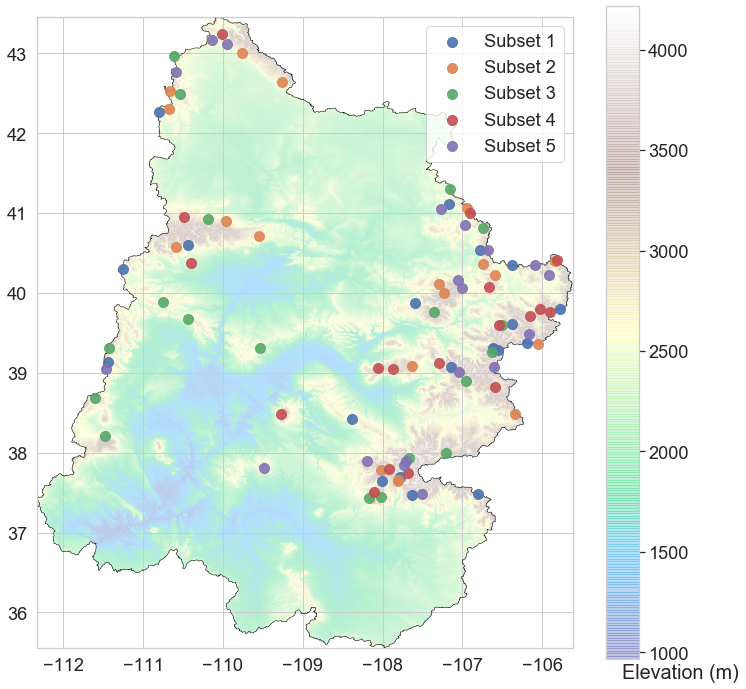

In [10]:
src = rio.open(DEMraster_path)

stations = pd.merge(Station_groups, Metadata_gdf, left_on='Station', right_on='StationID')
stations = gpd.GeoDataFrame(stations)

sns.set(font_scale=1.65, style='whitegrid')
fig, ax = plt.subplots(figsize=(12,12))

plt.imshow(src.read(1, masked=True), cmap='terrain', alpha=0.3)
UCWRR_Boundary.plot(facecolor='none', ax=ax, edgecolor='black', linewidth=0.5)

stations[stations['Subset'] == 1].plot(ax=ax, color='C0', alpha=0.9, markersize=100, label="Subset 1")
stations[stations['Subset'] == 2].plot(ax=ax, color='C1', alpha=0.9, markersize=100, label="Subset 2")
stations[stations['Subset'] == 3].plot(ax=ax, color='C2', alpha=0.9, markersize=100, label="Subset 3")
stations[stations['Subset'] == 4].plot(ax=ax, color='C3', alpha=0.9, markersize=100, label="Subset 4")
stations[stations['Subset'] == 5].plot(ax=ax, color='C4', alpha=0.9, markersize=100, label="Subset 5")

show(src.read(1, masked=True), ax=ax, cmap='terrain', transform=src.transform, alpha=0.3)
cbar = plt.colorbar()
cbar.ax.set_xlabel('Elevation (m)', ha='left')
plt.legend()

# plt.savefig('Sequential_subsets.png',dpi=300, bbox_inches='tight')
plt.show()

src.close()

## Plot artificially incomplete and complete datasets for different scenarios (Figure 4)

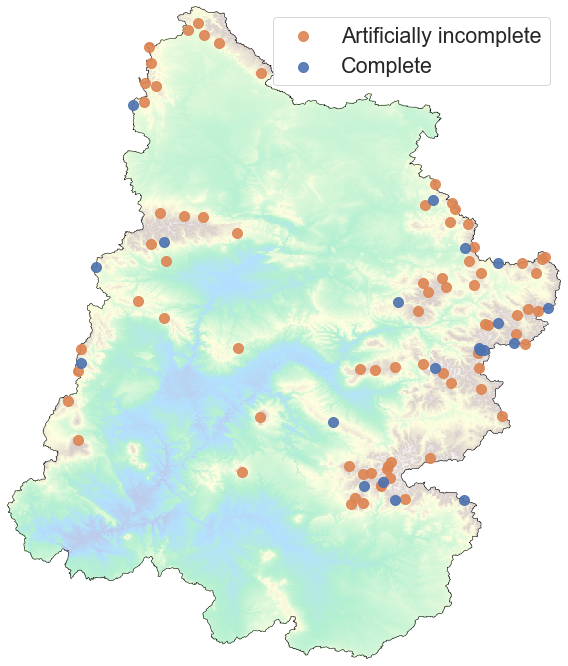

In [11]:
src = rio.open(DEMraster_path)
sns.set(font_scale=1.95, style='whitegrid')
fig, ax = plt.subplots(figsize=(12,12))

plt.imshow(src.read(1, masked=True), cmap='terrain', alpha=0.3)
UCWRR_Boundary.plot(facecolor='none', ax=ax, edgecolor='black', linewidth=0.5)

### Adjust the following subsets depending on which scenario needs to be visualized #################
####### Following is an example showing Scenario 1 ##################################################
stations[stations['Subset'] == 2].plot(ax=ax, color='C1', alpha=0.9, markersize=100, label="Artificially incomplete")
stations[stations['Subset'] == 3].plot(ax=ax, color='C1', alpha=0.9, markersize=100, label="")
stations[stations['Subset'] == 4].plot(ax=ax, color='C1', alpha=0.9, markersize=100, label="")
stations[stations['Subset'] == 5].plot(ax=ax, color='C1', alpha=0.9, markersize=100, label="")
stations[stations['Subset'] == 1].plot(ax=ax, color='C0', alpha=0.9, markersize=100, label="Complete")
######################################################################################################

show(src.read(1, masked=True), ax=ax, cmap='terrain', transform=src.transform, alpha=0.3)
plt.legend()

plt.axis('off')

# plt.savefig('Scenario1_subsets.png',dpi=150, bbox_inches='tight')
plt.show()

src.close()

# Scenarios (Pick one)

### Scenario 1

In [115]:
Complete_indices = [item for subset in Subsets[:1] for item in subset]
Incomplete_indices = [item for subset in Subsets[1:] for item in subset]

### Scenario 2

In [83]:
Complete_indices = [item for subset in Subsets[:2] for item in subset]
Incomplete_indices = [item for subset in Subsets[2:] for item in subset]

### Scenario 3

In [74]:
Complete_indices = [item for subset in Subsets[:3] for item in subset]
Incomplete_indices = [item for subset in Subsets[3:] for item in subset]

### Scenario 4

In [73]:
Complete_indices = [item for subset in Subsets[:4] for item in subset]
Incomplete_indices = list(Subsets[4])

# Numerical Experiments

### Non-sequential imputation

In [94]:
nse_list = []
dry_err_list = []
nse_extreme_list = []

fraction_missing = 0.2


for ID in Incomplete_indices:
    this_result = get_RF_NSE(ID, Complete_df, Complete_indices, fraction_missing = fraction_missing)
    nse_list.append(this_result[1])
    dry_err_list.append(this_result[2])
    nse_extreme_list.append(this_result[3])

NonSeq_NSE = pd.DataFrame({"ID":Incomplete_indices, "Station":Complete_df.columns[Incomplete_indices], "NonSeq_NSE":nse_list,
                             "NS_dry_err":dry_err_list, "NS_NSE_extreme":nse_extreme_list})

In [95]:
nsteps = Complete_df.shape[0]
mutual_corr_list = []
Seq_Complete_df = Complete_df.iloc[:, Complete_indices]

for ID in Incomplete_indices:
    train_indices, test_indices = train_test_split(np.arange(nsteps), test_size = fraction_missing, random_state = ID)
    data = Complete_df.iloc[train_indices, ID]
    mutual_corr = get_mutual_corr(Seq_Complete_df.iloc[train_indices,:], data, to_print=False)
    mutual_corr_list.append([item[1] for item in mutual_corr])


NonSeq_MC_df = pd.DataFrame(mutual_corr_list, index=Incomplete_indices)
NonSeq_MC_df['Agg_S2'] = np.sum(NonSeq_MC_df.iloc[:,:2], axis=1)

In [96]:
NonSeq_NSE = pd.merge(NonSeq_NSE, NonSeq_MC_df['Agg_S2'], left_on='ID', right_index=True)

### Sequential imputation

In [98]:
nsteps = Complete_df.shape[0]
seq_nse_list = []
seq_S2_list = []
seq_dry_err_list = []
seq_nse_extreme_list = []

Seq_Complete_df = Complete_df.iloc[:, Complete_indices]

n_iter = len(Incomplete_indices)

for iteration in np.arange(n_iter):
    mutual_corr_list = []

    for ID in Incomplete_indices:
        train_indices, test_indices = train_test_split(np.arange(nsteps), test_size = fraction_missing, random_state = ID)
        data = Complete_df.iloc[train_indices, ID]
        mutual_corr = get_mutual_corr(Seq_Complete_df.iloc[train_indices,:], data, to_print=False)
        mutual_corr_list.append([item[1] for item in mutual_corr])
        
    
    Incomp_MC_df = pd.DataFrame(mutual_corr_list, index=Incomplete_indices)
    Incomp_MC_df['Agg_MC'] = np.sum(Incomp_MC_df.iloc[:,:2], axis=1)
    Incomp_MC_df.sort_values(by=['Agg_MC'], ascending=False, inplace=True)
    seq_S2_list.append(Incomp_MC_df['Agg_MC'].iloc[0])
    index_to_impute = Incomp_MC_df.index[0]
    station_to_impute = Complete_df.iloc[:,index_to_impute]
    
    
    this_result = get_RF_NSE(index_to_impute, Complete_df, Complete_indices, fraction_missing = fraction_missing)
    seq_nse_list.append((index_to_impute, this_result[1], this_result[2], this_result[3], Incomp_MC_df['Agg_MC'].iloc[0]))
    Seq_Complete_df = pd.merge(Seq_Complete_df, this_result[0], left_index=True, right_index=True)
    
    Incomplete_indices.remove(index_to_impute)
    Complete_indices.append(index_to_impute)
    
    
    

# Construct dataframes (to save)

In [99]:
Seq_NSE = pd.DataFrame(seq_nse_list, columns=["ID","Seq_NSE","Seq_dry_err","Seq_NSE_extreme","Seq_S2"])
Compare_NSE = pd.merge(Seq_NSE, NonSeq_NSE)
Compare_NSE['Improvement'] = Compare_NSE['Seq_NSE'] - Compare_NSE['NonSeq_NSE']
Compare_NSE['Percent_change'] = (Compare_NSE['Seq_NSE'] - Compare_NSE['NonSeq_NSE'])/Compare_NSE['NonSeq_NSE']*100.0

# Save results

In [100]:
Compare_NSE.to_csv("../data_processed/Sequential_runs/Scenario1_CompareNSE.csv", index=True)
Seq_Complete_df.to_csv("../data_processed/Sequential_runs/Scenario1_Seq_Complete_df.csv", index=True)

# Load results (E.g. Scenario 1)

In [ ]:
Compare_NSE = pd.read_csv("../data_processed/Sequential_runs/Scenario1_CompareNSE.csv", index_col=0)
Seq_Complete_df = pd.read_csv("../data_processed/Sequential_runs/Scenario1_Seq_Complete_df.csv", index_col=0)

### Compare increment in NSE with standard deviation from ground truth

In [103]:
NSE_mean = pd.read_csv("../data_processed/Baseline_runs/Baseline_runs_NSEmean.csv")

In [106]:
Compare_NSE['Significant'] = (np.abs(Compare_NSE['Improvement']) - 1*NSE_mean['NSE (std)'][Compare_NSE['ID']].values) > 0
baseline_NSE = NSE_mean['NSE (mean)'][Compare_NSE['ID']].values
baseline_std = NSE_mean['NSE (std)'][Compare_NSE['ID']].values
x = np.arange(Compare_NSE.shape[0])

### Figure 8(a)
Update scenarios to get Figures 9(a), 10(a), 11(a)

Text(0.5, 0, 'Increment in sequence')

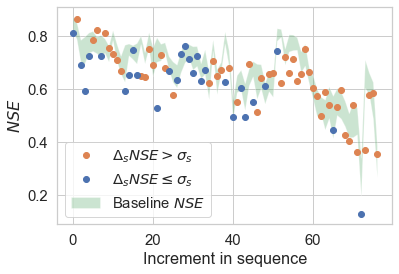

In [108]:
plt.fill_between(x,baseline_NSE-baseline_std,baseline_NSE+baseline_std,facecolor='C2',alpha=0.3,label='Baseline $NSE$')
plt.plot(Compare_NSE[Compare_NSE['Significant'] == True]['Seq_NSE'], 'C1o', label='$\Delta_s NSE > \sigma_s$')
plt.plot(Compare_NSE[Compare_NSE['Significant'] == False]['Seq_NSE'], 'C0o', label='$\Delta_s NSE \leq \sigma_s$')
plt.legend()

plt.ylabel('$NSE$')
plt.xlabel('Increment in sequence')

### Figure 8(b)
Update scenarios to get Figures 9(b), 10(b), 11(b)

Text(0.5, 0, 'Increment in sequence')

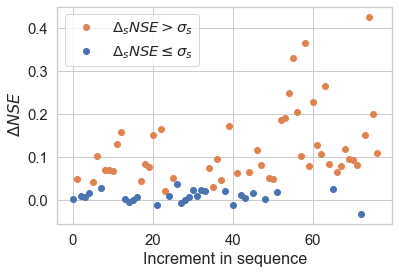

In [107]:
plt.plot(Compare_NSE[Compare_NSE['Significant'] == True]['Improvement'], 'C1o', label='$\Delta_s NSE > \sigma_s$')
plt.plot(Compare_NSE[Compare_NSE['Significant'] == False]['Improvement'], 'C0o', label='$\Delta_s NSE \leq \sigma_s$')
plt.legend()
plt.ylabel(' $\Delta NSE$')
plt.xlabel('Increment in sequence')

In [109]:
sum(Compare_NSE['Significant'] == True)

49

# Sample scatter plots

### Scenario 1

In [115]:
Complete_indices = [item for subset in Subsets[:1] for item in subset]
Incomplete_indices = [item for subset in Subsets[1:] for item in subset]

### Figure 12(a): Non-sequential imputation

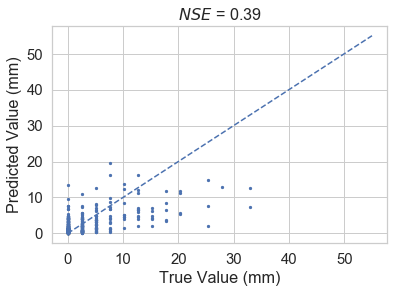

NSE (test): 0.38939823820990604


In [117]:
ex_ID=43

(rf, features) = train_rf(ex_ID, Complete_df, Complete_indices)
# plt.title('$NSE$=0.15')
# plt.savefig('sampleNonSeqImpute_ID43testing.png',dpi=300, bbox_inches='tight')
plt.show()

### Figure 12(b): Sequential imputation

Text(0.5, 1.0, '$NSE$ = 0.75')

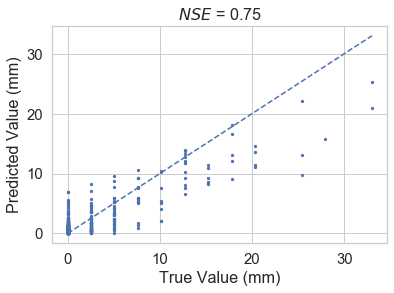

In [118]:
train_indices, test_indices = train_test_split(np.arange(nsteps), test_size = fraction_missing, random_state = ex_ID)
true_values = Complete_df.iloc[test_indices,ex_ID]
pred_values = Seq_Complete_df[Complete_df.iloc[:,ex_ID].name][test_indices]

plt.scatter(true_values, pred_values, s=5)


sns.set(font_scale=1.35, style='whitegrid')
plot_end = np.max([true_values, pred_values])
plt.plot([0, plot_end],[0, plot_end], '--')

plt.xlabel('True Value (mm)')
plt.ylabel('Predicted Value (mm)')
# plt.title('Precipitation: Testing')

textstr = "$NSE$ = " + str(round(get_NSE(true_values, pred_values),2))
plt.title(textstr)

# Sequential imputation results for modeling dry and extreme wet events

### Figure 14
Update to scenario 2 to get Figure 15

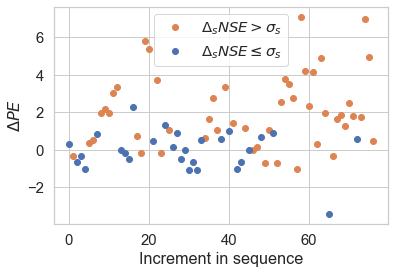

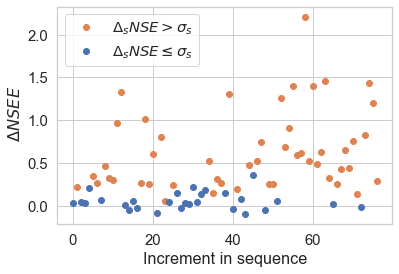

In [110]:
Compare_NSE['dry_improv'] =  (Compare_NSE['NS_dry_err']-Compare_NSE['Seq_dry_err'])*100

plt.plot(Compare_NSE[Compare_NSE['Significant'] == True]['dry_improv'],'C1o', label='$\Delta_s NSE > \sigma_s$')
plt.plot(Compare_NSE[Compare_NSE['Significant'] == False]['dry_improv'],'C0o', label='$\Delta_s NSE \leq \sigma_s$')
plt.legend()
plt.ylabel('$\Delta PE$')
plt.xlabel('Increment in sequence')
plt.show()

# plt.plot(Compare_NSE['NS_NSE_extreme'],'C1o')
# plt.plot(Compare_NSE['Seq_NSE_extreme'],'C2o')
# plt.show()

Compare_NSE['NSE_extreme_improv'] = Compare_NSE['Seq_NSE_extreme'] - Compare_NSE['NS_NSE_extreme']
plt.plot(Compare_NSE[Compare_NSE['Significant'] == True]['NSE_extreme_improv'],'C1o', label='$\Delta_s NSE > \sigma_s$')
plt.plot(Compare_NSE[Compare_NSE['Significant'] == False]['NSE_extreme_improv'],'C0o', label='$\Delta_s NSE \leq \sigma_s$')
plt.legend()
plt.ylabel(' $\Delta NSEE$')
plt.xlabel('Increment in sequence')
plt.show()


# Comparisons between $S_2$ for sequential and non-sequential imputations

### Figure 16(a)
Update to Scenario 2 to get Figure 16(b)

Text(0.5, 0, 'Increment in sequence')

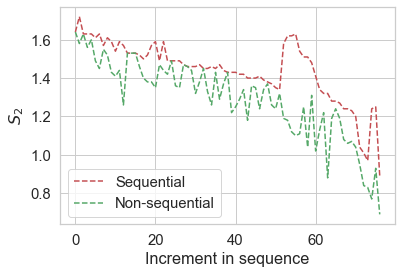

In [119]:
plt.plot(Compare_NSE['Seq_S2'], 'C3--', label='Sequential')
plt.plot(Compare_NSE['Agg_S2'], 'C2--', label='Non-sequential')

plt.legend()
plt.ylabel('$S_2$')
plt.xlabel('Increment in sequence')